In [24]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import time
# dec. sobre a função: @jit(nopython=True)

Iterations: 199


Text(0, 0.5, 'Potencial (V)')

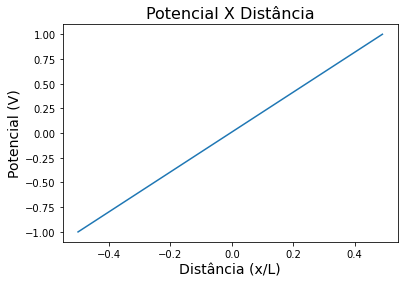

In [96]:
## Unidimensional Region Between Plates ##

n = 100
initialGuess = np.zeros(n)
initialGuess[-1], initialGuess[0] = 1, -1
domain = np.arange(n)/n - 0.5
w = 1.941

# SOR Method #
def sorMethod1D(potential, convergenceCriteria, w):
    n = potential.shape[0]
    iterations = 0
    residue = 1
    wBest, nIterations = 0, 10000
    
    while residue > convergenceCriteria:
        iterations += 1
        formerPotential = np.copy(potential)
        for j in range(1, n-1):
            potential[j] = (1-w)*potential[j] + w*(potential[j-1] + potential[j+1])/2
        residue = np.linalg.norm(potential - formerPotential)
        if iterations >= 20000:
            print(f'Exceeded maximum iterations allowed (w = {w})')
            print(f'Current residue: {residue}')
            break        
    return (potential, iterations)

potentialBetweenPlates, iterations = sorMethod1D(initialGuess, 1e-4, w)


print(f'Iterations: {iterations}')
plt.plot(domain , potentialBetweenPlates)
plt.title("Potencial X Distância", fontsize=16)
plt.xlabel("Distância (x/L)", fontsize=14)
plt.ylabel("Potencial (V)", fontsize=14)